## Mitigation and adaptation emissions embedded in the broader climate transition
Corey Lesk, Denes Csala, Robin Hasse, Sgouris Sgouridis, Antoine Levesque, Katharine Mach,
Daniel Horen Greenford, H. Damon Matthews, Radley Horton

#### Sensitivity test for alternate transition parameters in NETSET
*  This code runs the sensitivity tests shown in Figure S3
*  Requires the NETSET outputs for sensitivty runs under varying transition assumptions (netset_sensitivity folder, included)

In [5]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gspec
%matplotlib inline

In [142]:
netsetDir = '\\netset_sensitivity\\'

#### netset Sensitivity runs

In [97]:
escens = ['2000W','2500W','3000W']
tscens = ['2020','2030','2040']

start_year = 2020
alpha1 = 3600 #Joules per Watt-hour
EFs = {'coal':90,'oil':60,'gas':50}

cumEmsTotal = {}

for escen in escens:
    for tscen in tscens:
        
        cumEmsTotal[escen+'_'+tscen] = []


cumEmsTotal


{'2000W_2020': [],
 '2000W_2030': [],
 '2000W_2040': [],
 '2500W_2020': [],
 '2500W_2030': [],
 '2500W_2040': [],
 '3000W_2020': [],
 '3000W_2030': [],
 '3000W_2040': []}

In [98]:
### load and process netset output for each sensitivity run, compute cumulative emissions
for escen in escens:
    for tscen in tscens:
        
        if (tscen == '2020') & (escen == '2000W'):
            cumEmsTotal['2000W_2020'] = [94.6]
            continue
            
        ### load and prep data for plotting
        df=pd.read_excel(netsetDir+'sensitivity_' + tscen + '_' + escen + '.xlsx',sheet_name='net')
        sets={}
        df=df.set_index('Unnamed: 0')
        for n in df.columns:
            sets[n]=[[],[]]
            x=df[n].index
            m=df[n].to_numpy()
            for i in range(len(x)):
                sets[n][0].append(x[i])
                sets[n][1].append(m[i])

        df=pd.read_excel(netsetDir+'sensitivity_' + tscen + '_' + escen + '.xlsx',sheet_name='gross')
        df=df.set_index('Unnamed: 0')
        sets2={}
        for n in df.columns:
            sets2[n]=[[],[]]
            x=df[n].index
            m=df[n].to_numpy()
            for i in range(len(x)):
                sets2[n][0].append(x[i])
                sets2[n][1].append(m[i])
        sets2.pop('net');

        emissions = {}

        for fuel in EFs.keys():

            emissions[fuel] = [j*alpha1*EFs[fuel]/10**9 for j in sets2[fuel][1]] #Twh*(TJ/TWh)*(tCO2/TJ)*(GtCO2/tCO2)
            
        start_ind = np.where(np.array(sets2['coal'][0]) == start_year)[0][0]
        cum_ems_total = 0

        for fuel in EFs.keys():

            cum_ems_total += sum(emissions[fuel][start_ind:])
        
        cumEmsTotal[escen + '_' + tscen] = [cum_ems_total]


In [17]:
cumEmsTotal

{'2000W_2020': [94.6],
 '2000W_2030': [90.48775903200001],
 '2000W_2040': [87.51753925412693],
 '2500W_2020': [96.86697274799998],
 '2500W_2030': [92.74681396799998],
 '2500W_2040': [93.38228694144334],
 '3000w_2020': [98.80172654399999],
 '3000w_2030': [94.19537224799998],
 '3000w_2040': [114.1954917258009]}

In [99]:
### reformat data to grid for plotting
emsGrid = np.zeros(9)

for i,escen in enumerate(escens):
    for j,tscen in enumerate(tscens):
        
        ind = 3*i + j
        emsGrid[ind] = cumEmsTotal[escen + '_' + tscen][0]

emsGrid = emsGrid.reshape((3,3))
emsFracGrid = 100*np.round(emsGrid/emsGrid[0,0],3) 

In [103]:
(emsGrid.sum()-100)/8

95.3492453076714

In [96]:
### set up the colormap for plotting
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

arr = np.linspace(0, 50, 100).reshape((10, 10))

cmap = plt.get_cmap('Purples')
new_cmap = truncate_colormap(cmap, 0, 0.6)


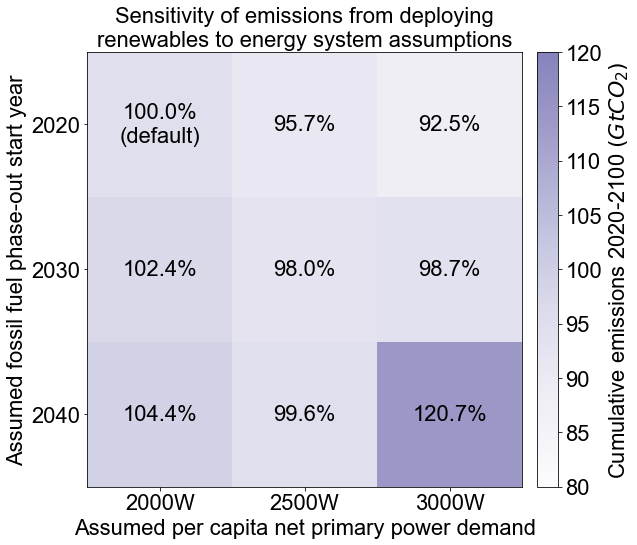

In [184]:

from mpl_toolkits.axes_grid1 import make_axes_locatable
plt.rcParams['font.sans-serif'] = "Arial"
plt.rcParams['font.family'] = "sans-serif"
plt.rcParams['font.size'] = 22
fsize = 22

fig,ax = plt.subplots(figsize=(10,8))

im=ax.imshow(emsGrid,cmap=new_cmap, norm=norm)#, vmin=80,vmax=140)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.2)
fig.colorbar(im, cax=cax, orientation='vertical',label=r'Cumulative emissions 2020-2100 $(GtCO_2)$')

for i in range(len(escens)):
    for j in range(len(tscens)):
        if (i==0) & (j==0):
            text = ax.text(j, i, str(emsFracGrid[i, j]) + '%\n(default)',
                           ha="center", va="center", color="k")            
        else:    
            text = ax.text(j, i, str(emsFracGrid[i, j]) + '%',
                       ha="center", va="center", color="k")

ax.set_xticks(np.arange(len(escens)))
ax.set_xticklabels(escens)
ax.set_yticks(np.arange(len(tscens)))
ax.set_yticklabels(tscens)

ax.set_ylabel('Assumed fossil fuel phase-out start year')
ax.set_xlabel('Assumed per capita net primary power demand')
ax.set_title('Sensitivity of emissions from deploying\nrenewables to energy system assumptions',fontsize=22)

